# DAP Project

***

## 개요

### 네트워크 침입 탐지
네트워크 트래픽을 감시하여 서비스 거부 공격(DoS 공격), 포트 스캔, 컴퓨터를 크랙하려는 시도 등과 같은 악의적인 동작을 탐지하는 것을 말한다. 탐지하는 방식에 따라 규칙 기반 침입 탐지와 이상 침입 탐지 방식이 있다.[[ref]](https://ko.wikipedia.org/wiki/%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC_%EC%B9%A8%EC%9E%85_%ED%83%90%EC%A7%80_%EC%8B%9C%EC%8A%A4%ED%85%9C)

#### 규칙 기반 침입 탐지
네트워크 정보, 알려진 침입방법, 비정상적인 행위 패턴등의 특징을 비교하여 일치할 경우 탐지하는 방식이다. 기존의 침입방식을 데이터베이스에 저장해 두었다가 사용자 행동 패턴이 기존의 침입 패턴과 일치하거나 유사한 경우 침입이라고 판단한다. 오탐률이 낮다는 장점이 있지만 패턴에 없는 새로운 공격(Zero day Attack)에 대해서는 탐지가 불가능하다는 단점이 존재한다.

#### 이상 침입 탐지
관찰된 사건들을 정상적인 행위에 대한 정의들과 비교하여 비정상 행위를 식별하는 것을 말한다. 인공지능 알고리즘을 사용하여 스스로 판단이 가능하다. 새로운 공격에 대한 탐지가 가능하다는 장점이 있다. 다만 오탐이 발생할수 있다.[[ref]](https://didimdol20.tistory.com/62)
    
    
#### 목표
정상, 비정상 트래픽으로 라벨링이 되어있는 네트워크 트래픽에 관한 데이터세트를 통해 데이터를 Data Processing, Visualization, Classification 과정을 통해 비정상 트래픽을 식별하는 모델을 만드는 것이 목표이다. Classification 방식은 Logistic Regression, kNN Classifier, Naïve Bayes, , Support Vector Machine 모두 적용해보고 가장 성능이 좋은 모델을 사용하여 라벨링이 되어 있지 않는 complete.csv 데이터를 분류 하는것이 목표이다.

    


## 0. 관련 라이브러리 

In [160]:

# 패키지 import

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## 1. 데이터세트

### ADES-2021 Dataset [[Link]](https://www.kaggle.com/c/ades-2021/)
나쁜 연결(침입또는 공격)과 좋은(정상)연결을 구별하는 예측 모델을 개발하기 위해 제공 되는 데이터세트로 모델 개발을 위한 dev.csv과 개발한 모델을 통해 정상/비정상 트래픽으로 분류해야하는 compete.csv가 제공된다.

dev.csv는 네트워크에 관한 다양한 정보와 정상/비정상 트래픽임을 알리는 class(0: 비정상, 1:정상)을 포함하여 42개의 Columns와 345815개의 Rows로 구성된다. 

compete.csv는 class을 제외한 41개의 Columns와 148206개의 Rows로 구성된다.

#### Dev.csv 간략한 정보

In [106]:
# 데이터 가져오기

dev = pd.read_csv('https://raw.githubusercontent.com/leebs0521/DAP/main/Dataset/ades-2021/dev.csv')
nRow, nCol = dev.shape
print("Dev Data has {} rows & {} columns".format(nRow, nCol))
dev.head()

Dev Data has 345815 rows & 42 columns


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,udp,private,SF,105,147,0,0,0,0,...,56,0.60,0.03,0.01,0.00,0.0,0.0,0.0,0.00,0
1,4,udp,private,SF,105,147,0,0,0,0,...,250,0.98,0.01,0.01,0.00,0.0,0.0,0.0,0.00,0
2,0,tcp,http,REJ,0,0,0,0,0,0,...,255,1.00,0.00,0.08,0.24,0.0,0.0,1.0,0.99,0
3,0,tcp,http,SF,310,2268,0,0,0,0,...,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.00,0
4,0,udp,domain_u,SF,46,46,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0


In [107]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345815 entries, 0 to 345814
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     345815 non-null  int64  
 1   protocol_type                345815 non-null  object 
 2   service                      345815 non-null  object 
 3   flag                         345815 non-null  object 
 4   src_bytes                    345815 non-null  int64  
 5   dst_bytes                    345815 non-null  int64  
 6   land                         345815 non-null  int64  
 7   wrong_fragment               345815 non-null  int64  
 8   urgent                       345815 non-null  int64  
 9   hot                          345815 non-null  int64  
 10  num_failed_logins            345815 non-null  int64  
 11  logged_in                    345815 non-null  int64  
 12  num_compromised              345815 non-null  int64  
 13 

In [108]:
dev.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
count,345815.000000,3.458150e+05,3.458150e+05,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,...,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000,345815.000000
mean,47.629866,1.652131e+03,8.780215e+02,0.000046,0.006278,0.000014,0.034863,0.000159,0.148238,0.009881,...,188.719954,0.754079,0.031016,0.602577,0.006650,0.176193,0.175861,0.058245,0.057501,0.803088
std,693.577062,5.905801e+04,3.331798e+04,0.006802,0.133003,0.006131,0.786947,0.016919,0.355336,1.534885,...,106.003839,0.410574,0.109775,0.481140,0.041933,0.380109,0.380426,0.230823,0.230283,0.397666
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,42088.000000,5.135678e+06,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,767.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### complete.csv 간략한 정보

In [111]:
# compete.csv 데이터 가져오기

compete = pd.read_csv('https://raw.githubusercontent.com/leebs0521/DAP/main/Dataset/ades-2021/compete.csv')
nRow, nCol = compete.shape
print("Compete Data has {} rows & {} columns".format(nRow, nCol))
compete.head()

Compete Data has 148206 rows & 42 columns


,Id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,0,tcp,http,SF,239,486,0,0,0,...,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0
1,2,0,tcp,http,SF,235,1337,0,0,0,...,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
2,3,0,tcp,http,SF,219,1337,0,0,0,...,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0
3,4,0,tcp,http,SF,212,1940,0,0,0,...,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0
4,5,0,tcp,http,SF,159,4087,0,0,0,...,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0


In [113]:
compete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148206 entries, 0 to 148205
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Id                           148206 non-null  int64  
 1   duration                     148206 non-null  int64  
 2   protocol_type                148206 non-null  object 
 3   service                      148206 non-null  object 
 4   flag                         148206 non-null  object 
 5   src_bytes                    148206 non-null  int64  
 6   dst_bytes                    148206 non-null  int64  
 7   land                         148206 non-null  int64  
 8   wrong_fragment               148206 non-null  int64  
 9   urgent                       148206 non-null  int64  
 10  hot                          148206 non-null  int64  
 11  num_failed_logins            148206 non-null  int64  
 12  logged_in                    148206 non-null  int64  
 13 

In [114]:
compete.describe()

,Id,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,148206.000000,148206.000000,1.482060e+05,1.482060e+05,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,...,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000,148206.000000
mean,74103.500000,48.794657,6.230404e+03,8.463912e+02,0.000040,0.006795,0.000013,0.033717,0.000135,0.148267,...,232.523724,188.539007,0.753082,0.030649,0.600437,0.006761,0.178063,0.177799,0.057819,0.057204
std,42783.531335,739.755576,1.801976e+06,3.238220e+04,0.006363,0.138920,0.003674,0.770682,0.011616,0.355365,...,64.714773,106.126033,0.411264,0.108046,0.481702,0.042595,0.381719,0.382066,0.230044,0.229808
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37052.250000,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,43.000000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74103.500000,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,111154.750000,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,148206.000000,58329.000000,6.933756e+08,5.151385e+06,1.000000,3.000000,1.000000,30.000000,1.000000,1.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Data Processing
### 1. missing values
    해당 데이터 세트는 결측값이 존재하지 않는다.

In [141]:
data = dev

# nan 값이 있는지 체크
data.isnull().sum()

# object 타입중 "Unknown" 데이터가 있는지 체크
#for col in data.select_dtypes("object"):
#   data[data[col]=="Unknown"]
          

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
wrong_fragment                 0
hot                            0
logged_in                      0
num_compromised                0
num_root                       0
num_access_files               0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_srv_count             0
dst_host_same_srv_rate         0
dst_host_diff_srv_rate         0
dst_host_same_src_port_rate    0
dst_host_srv_diff_host_rate    0
dst_host_serror_rate           0
dst_host_srv_serror_rate       0
dst_host_r

### 2. 단일값을 가지는 행 제거
    단일 값 및 거의 단일 값인 행을 제거
    * 총 데이터 수 = 345815 이므로 34500이상 부터 단일 값으로 간주

In [119]:
# 단일 값만 가지는 행 찾기

drop_list = []
for col in data.columns:
    temp = data[col].value_counts()[0]
    if temp > 345500 :
        #print(data[col].value_counts())
        drop_list.append(col)
        
print(drop_list)

['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_outbound_cmds', 'is_host_login']


In [120]:
# 단일 값 행 제거

data.drop(drop_list, axis=1, inplace = True)
print(data.shape)

(345815, 33)


### 3. Data Encoding & Data Scaling
    1. 데이터 타입이 'Object'인 데이터 Label Encoder를 통해 인코딩
    2. 정규화를 통해 데이터 스케일링

In [121]:
# 학습을 위해 데이터를  X(라벨 값을 제외한), Y(라벨 값)으로 분류

X = data.drop("class", axis = 1);
Y = data["class"]
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,udp,private,SF,105,147,0,0,0,0,...,94,56,0.60,0.03,0.01,0.00,0.0,0.0,0.0,0.00
1,4,udp,private,SF,105,147,0,0,0,0,...,255,250,0.98,0.01,0.01,0.00,0.0,0.0,0.0,0.00
2,0,tcp,http,REJ,0,0,0,0,0,0,...,13,255,1.00,0.00,0.08,0.24,0.0,0.0,1.0,0.99
3,0,tcp,http,SF,310,2268,0,0,1,0,...,22,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.00
4,0,udp,domain_u,SF,46,46,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00


In [122]:
le = LabelEncoderExt()

# 'object'타입 데이터를 라벨 인코더로 인코딩
for col in X.select_dtypes("object"):
  le.fit(X[col])
  X[col] = le.transform(X[col])

In [123]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,3,46,9,105,147,0,0,0,0,...,94,56,0.60,0.03,0.01,0.00,0.0,0.0,0.0,0.00
1,4,3,46,9,105,147,0,0,0,0,...,255,250,0.98,0.01,0.01,0.00,0.0,0.0,0.0,0.00
2,0,2,23,1,0,0,0,0,0,0,...,13,255,1.00,0.00,0.08,0.24,0.0,0.0,1.0,0.99
3,0,2,23,9,310,2268,0,0,1,0,...,22,255,1.00,0.00,0.05,0.04,0.0,0.0,0.0,0.00
4,0,3,12,9,46,46,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00


In [124]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Columns 정보를 저장
cols = X.columns

# 데이터를 정규화로 스케일링
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = cols)
X_scaled.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,-0.068673,2.663283,1.596894,0.513572,-0.026197,-0.021941,-0.047201,-0.044301,-0.417178,-0.006438,...,-2.137914,-1.252032,-0.375277,-0.009251,-1.231611,-0.158594,-0.463534,-0.462275,-0.252338,-0.249695
1,-0.062906,2.663283,1.596894,0.513572,-0.026197,-0.021941,-0.047201,-0.044301,-0.417178,-0.006438,...,0.348246,0.578094,0.550258,-0.191443,-1.231611,-0.158594,-0.463534,-0.462275,-0.252338,-0.249695
2,-0.068673,0.926252,-0.102775,-3.040241,-0.027975,-0.026353,-0.047201,-0.044301,-0.417178,-0.006438,...,-3.388716,0.625262,0.598970,-0.282539,-1.086123,5.564812,-0.463534,-0.462275,4.079990,4.049368
3,-0.068673,0.926252,-0.102775,0.513572,-0.022726,0.041719,-0.047201,-0.044301,2.397060,-0.006438,...,-3.249738,0.625262,0.598970,-0.282539,-1.148475,0.795307,-0.463534,-0.462275,-0.252338,-0.249695
4,-0.068673,2.663283,-0.915660,0.513572,-0.027196,-0.024972,-0.047201,-0.044301,-0.417178,-0.006438,...,0.348246,0.625262,0.598970,-0.282539,-1.252395,-0.158594,-0.463534,-0.462275,-0.252338,-0.249695


### 4. Feature Selection
Columns가 너무 많으므로 랜덤포레스트를 통하여 Feature importance를 구해보고 15개의 Columns를 선택한다.

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

In [126]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(X_train, Y_train)

feature_imp = pd.DataFrame({'feature':X_train.columns,'importance':rfc.feature_importances_})
feature_imp = feature_imp.sort_values('importance',ascending=False).set_index('feature')

In [127]:
print(feature_imp)

                             importance
feature                                
count                          0.232008
dst_bytes                      0.122004
logged_in                      0.093568
dst_host_count                 0.075270
protocol_type                  0.065131
src_bytes                      0.057426
srv_count                      0.056181
dst_host_same_src_port_rate    0.054206
dst_host_same_srv_rate         0.043246
dst_host_srv_diff_host_rate    0.030859
diff_srv_rate                  0.023244
srv_diff_host_rate             0.019750
same_srv_rate                  0.016666
flag                           0.012690
service                        0.012588
dst_host_srv_count             0.011965
dst_host_serror_rate           0.011189
dst_host_diff_srv_rate         0.010619
hot                            0.008859
srv_serror_rate                0.007495
duration                       0.006349
num_compromised                0.005176
serror_rate                    0.005070


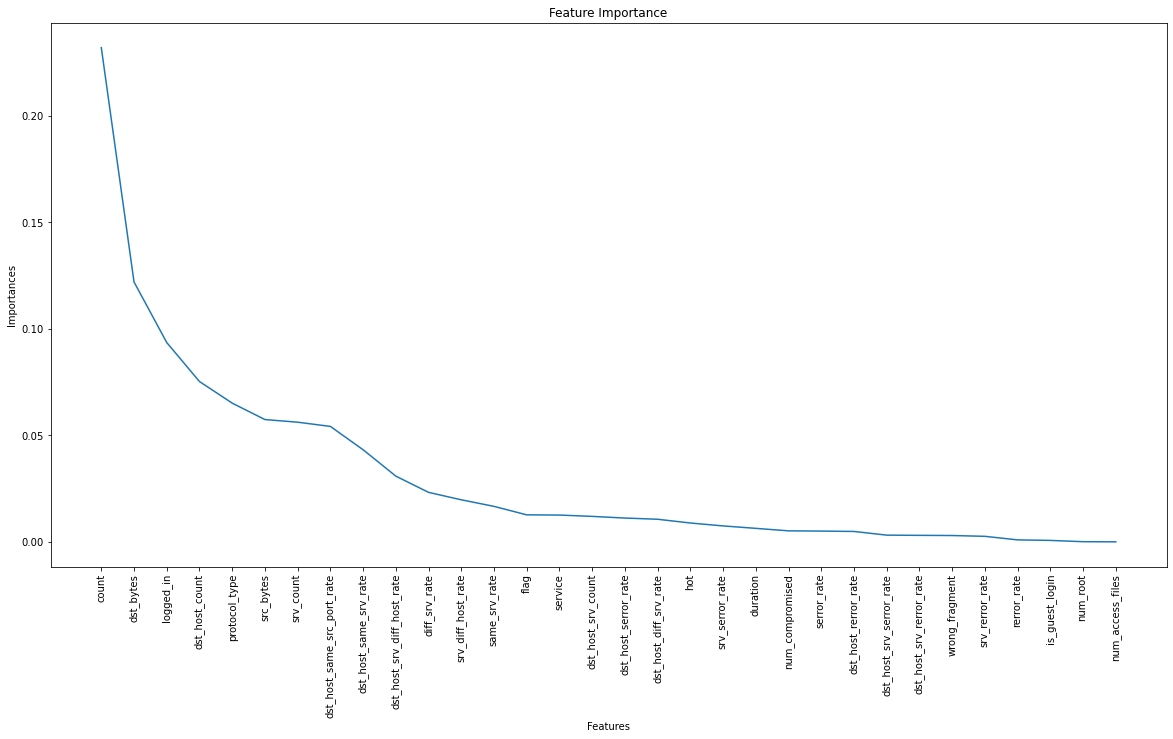

In [131]:
# Feature Importance 시각화
plt.figure(figsize = (20, 10))
plt.title("Feature Importance")
plt.ylabel("Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.plot(feature_imp)

In [132]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# Random Forest를 통해 15개의 Columns를 선택
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(X_train, Y_train)

# 선택된 Columns 출력
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate']

In [130]:
X_select = X_scaled[selected_features]

X_select.head()

,protocol_type,service,flag,src_bytes,dst_bytes,hot,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
0,2.663283,1.596894,0.513572,-0.026197,-0.021941,-0.044301,-0.417178,-1.554799,-1.186143,0.536333,-0.254881,-2.137914,-0.375277,-1.231611,-0.158594
1,2.663283,1.596894,0.513572,-0.026197,-0.021941,-0.044301,-0.417178,-1.550108,-1.182083,0.536333,-0.254881,0.348246,0.550258,-1.231611,-0.158594
2,0.926252,-0.102775,-3.040241,-0.027975,-0.026353,-0.044301,-0.417178,-1.554799,-1.186143,0.536333,-0.254881,-3.388716,0.598970,-1.086123,5.564812
3,0.926252,-0.102775,0.513572,-0.022726,0.041719,-0.044301,2.397060,-1.531343,-1.165842,0.536333,-0.254881,-3.249738,0.598970,-1.148475,0.795307
4,2.663283,-0.915660,0.513572,-0.027196,-0.024972,-0.044301,-0.417178,-1.306164,-0.970952,0.536333,-0.254881,0.348246,0.598970,-1.252395,-0.158594


## 3. Visualiztaion 

Text(0.5, 1.0, 'Bad(0), Good(1)')

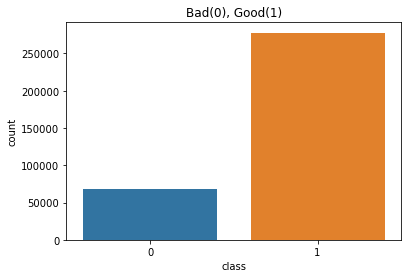

In [169]:
# Dev 데이터세트의 정상/ 비정상 데이터 분포
import warnings
warnings.filterwarnings('ignore')
p = sns.countplot(Y)
p.set_title("Bad(0), Good(1)")

Text(0.5, 1.0, 'Protocol Bad/Good')

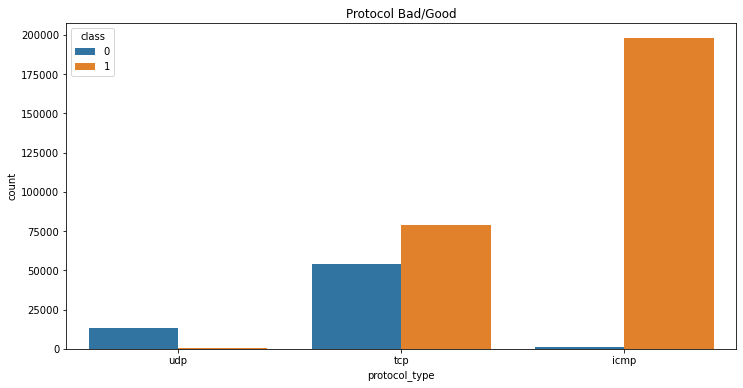

In [176]:
# 프로토콜별 정상 / 비정상 분포
plt.figure(figsize=(12,6))
p = sns.countplot(data[selected_features]['protocol_type'],hue = Y)
p.set_title("Protocol Bad/Good")

Text(0.5, 1.0, 'service Bad/Good')

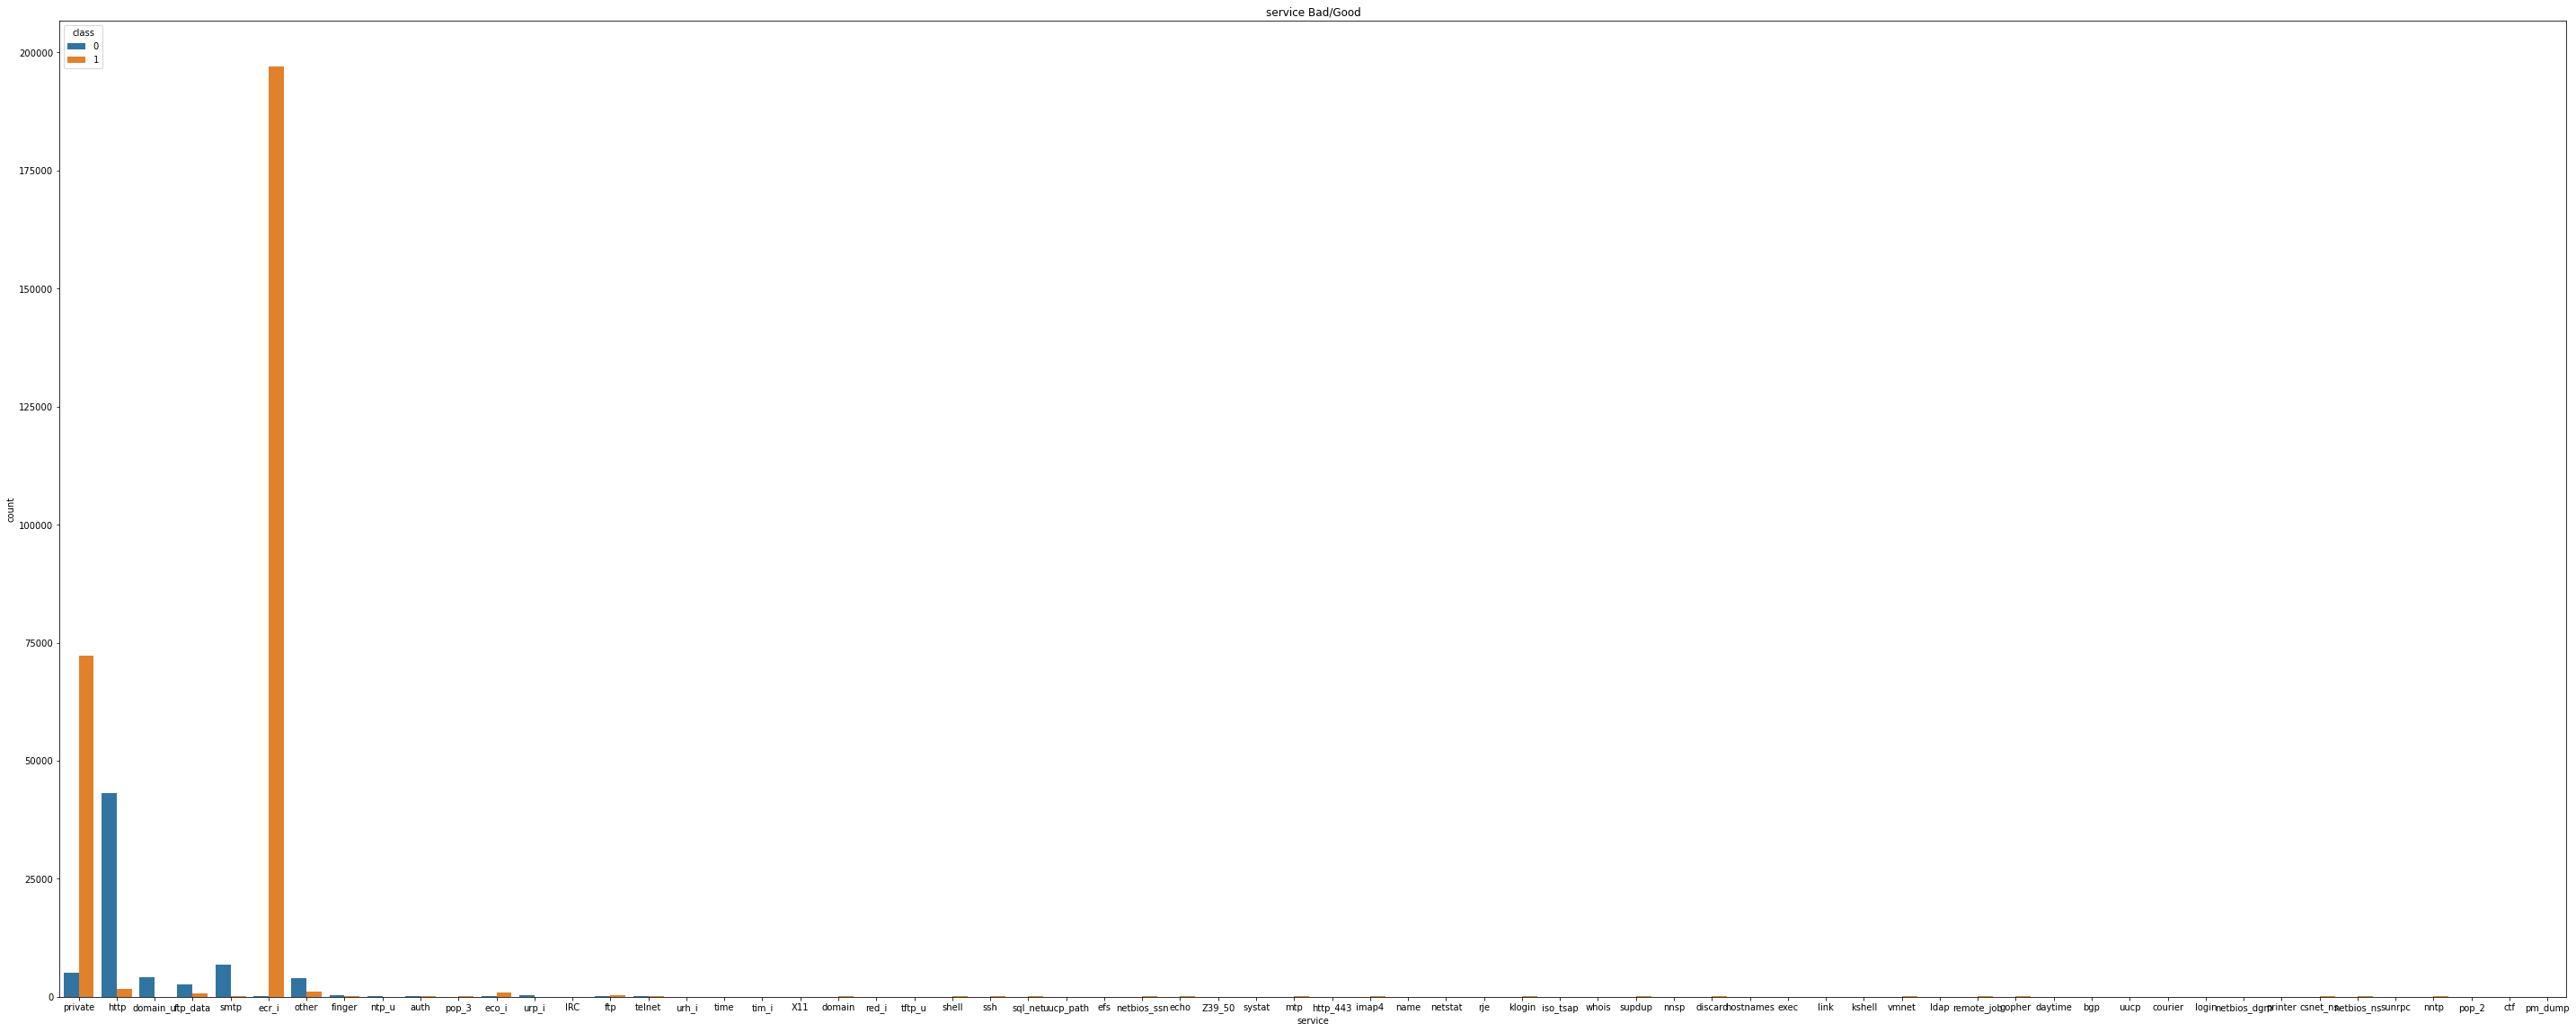

In [182]:
# 서비스별 정상 / 비정상 분포
plt.figure(figsize=(50,20))
p = sns.countplot(data[selected_features]['service'],hue = Y)
p.set_title("service Bad/Good")

Text(0.5, 1.0, 'Corr')

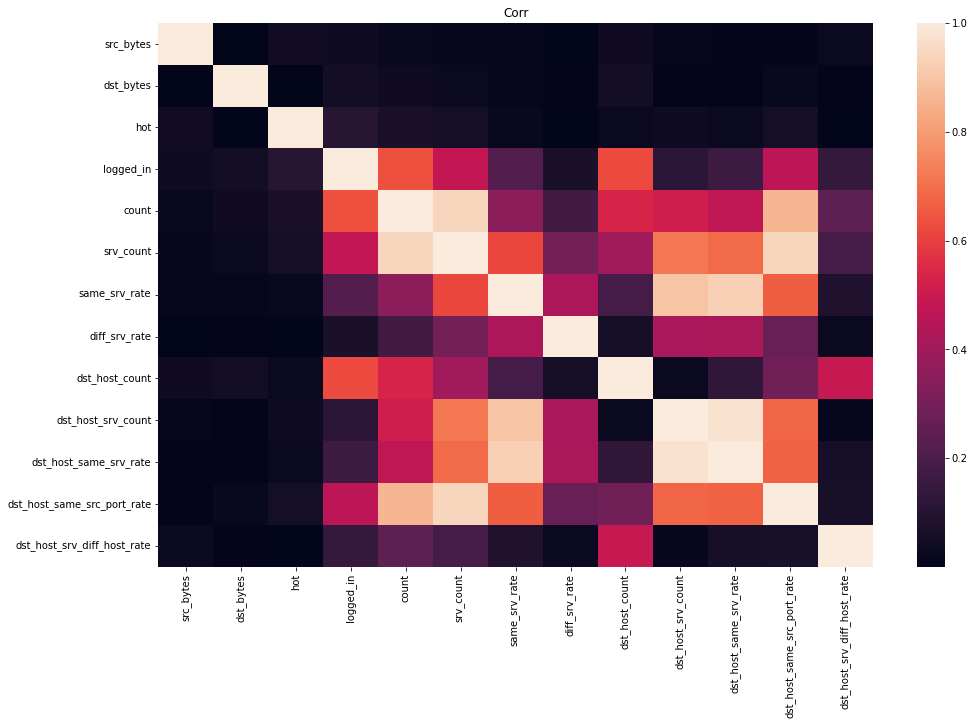

In [186]:
# 상관 계수
plt.figure(figsize=(16,10))
p = sns.heatmap(data[selected_features].corr().apply(abs))
p.set_title("Corr")

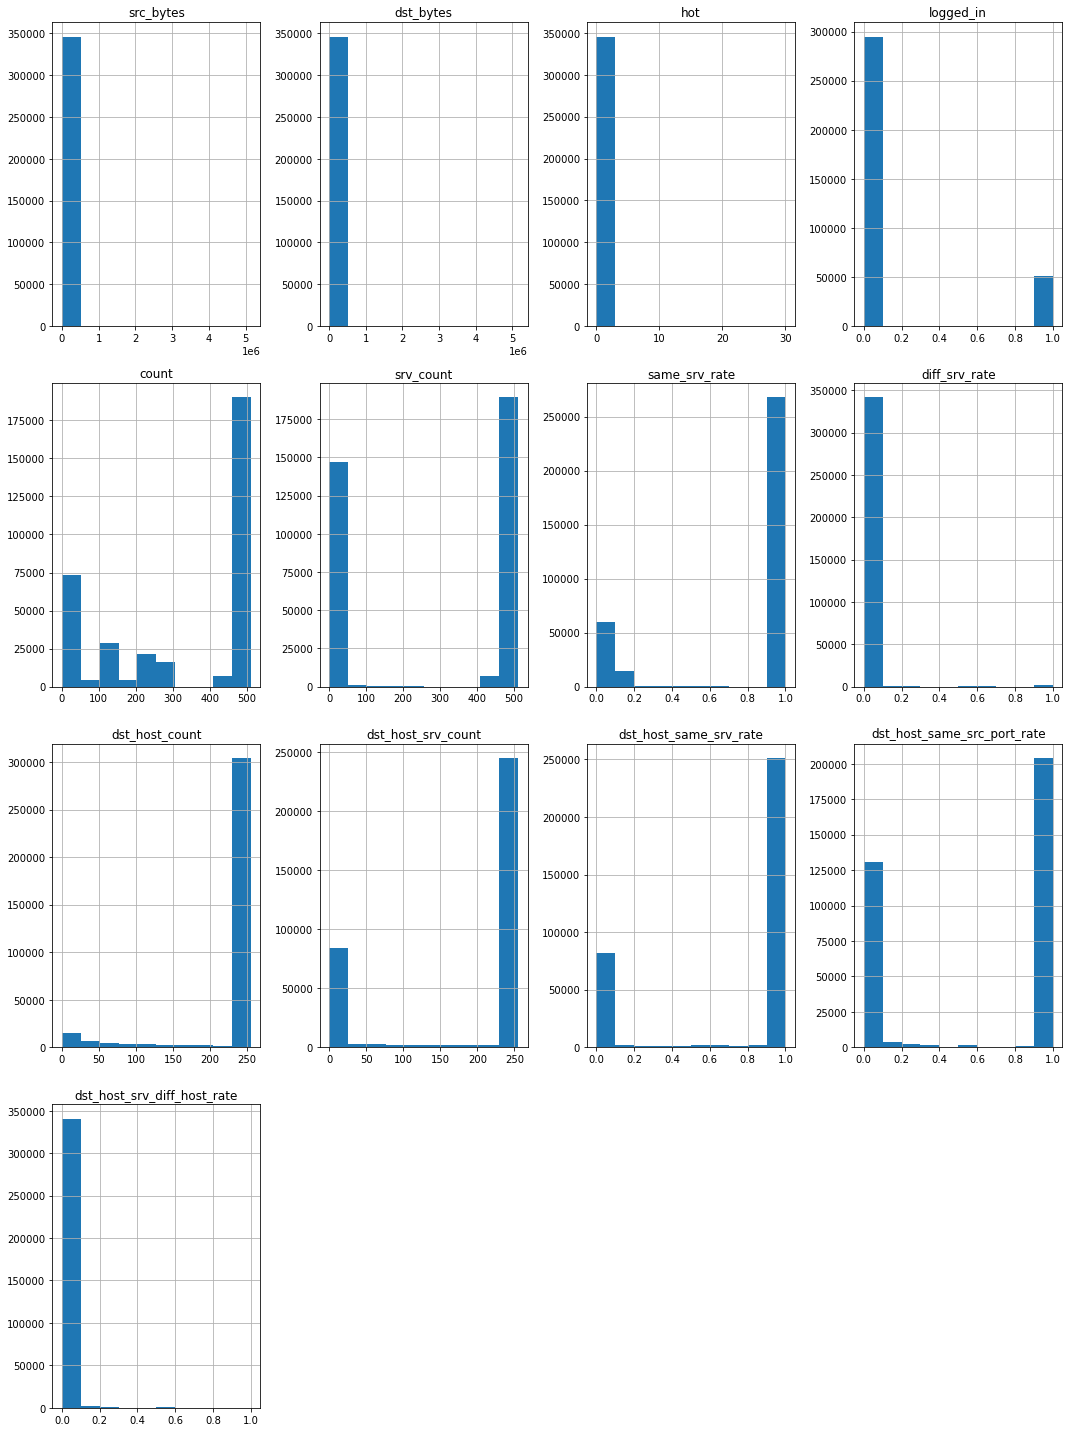

In [188]:
# numerical 데이터에 대한 히스토그램
data[selected_features].hist(bins=10, figsize=(15,20))
plt.tight_layout()
plt.show()

## 4. Classification
Data Processing을 통해 가공된 데이터를 4개의 Classification 방식으로 학습
1. Logistic Regression
2. kNN
3. Naive Bayes
4. SVM


In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_select, Y, test_size=0.3, random_state=42)

In [145]:
X_train

,protocol_type,service,flag,src_bytes,dst_bytes,hot,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
214353,0.926252,1.596894,-1.263334,-0.027975,-0.026353,-0.044301,-0.417178,-0.260017,-1.186143,-2.041129,0.474643,0.348246,-1.836648,-1.252395,-0.158594
98518,-0.810778,-0.693964,0.513572,-0.010500,-0.026353,-0.044301,-0.417178,0.837732,0.884561,0.536333,-0.254881,0.348246,0.598970,0.826004,-0.158594
182931,0.926252,1.596894,-1.263334,-0.027975,-0.026353,-0.044301,-0.417178,-0.184958,-1.108999,-1.860707,0.353056,0.348246,-1.641798,-1.252395,-0.158594
210378,0.926252,1.596894,-1.263334,-0.027975,-0.026353,-0.044301,-0.417178,-0.241252,-1.137421,-1.912256,0.474643,0.348246,-1.714867,-1.252395,-0.158594
159878,-0.810778,-0.693964,0.513572,-0.010500,-0.026353,-0.044301,-0.417178,0.833041,0.880500,0.536333,-0.254881,0.348246,0.598970,0.826004,-0.158594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.810778,-0.693964,0.513572,-0.019170,-0.026353,-0.044301,-0.417178,0.837732,0.884561,0.536333,-0.254881,0.348246,0.598970,0.826004,-0.158594
259178,-0.810778,-0.693964,0.513572,-0.010500,-0.026353,-0.044301,-0.417178,0.837732,0.884561,0.536333,-0.254881,0.348246,0.598970,0.826004,-0.158594
131932,0.926252,1.596894,-1.263334,-0.027975,-0.026353,-0.044301,-0.417178,-0.907408,-1.137421,-1.809157,0.474643,0.348246,-1.690511,-1.252395,-0.158594
146867,-0.810778,-0.693964,0.513572,-0.019170,-0.026353,-0.044301,-0.417178,0.837732,0.884561,0.536333,-0.254881,0.348246,0.598970,0.826004,-0.158594


### Logistic Regression

In [146]:
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(solver='lbfgs', max_iter=400)

# fit the model with data
logreg.fit(X_train, Y_train)

# Forecast the target variable for given test dataset
logreg_predictions = logreg.predict(X_test)

In [147]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, logreg_predictions))

[[20273   198]
 [  976 82298]]


In [148]:
print(classification_report(Y_test, logreg_predictions, digits = 5))

              precision    recall  f1-score   support

           0    0.95407   0.99033   0.97186     20471
           1    0.99760   0.98828   0.99292     83274

    accuracy                        0.98868    103745
   macro avg    0.97583   0.98930   0.98239    103745
weighted avg    0.98901   0.98868   0.98876    103745



### kNN

In [149]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier object
knn = KNeighborsClassifier(n_neighbors = 3)

# Train the model using the training dataset
knn.fit(X_train, Y_train)

# Predict the target variable for test dataset
knn_predictions = knn.predict(X_test)

In [150]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, knn_predictions))

[[20431    40]
 [   44 83230]]


In [151]:
print(classification_report(Y_test, knn_predictions, digits = 5))

              precision    recall  f1-score   support

           0    0.99785   0.99805   0.99795     20471
           1    0.99952   0.99947   0.99950     83274

    accuracy                        0.99919    103745
   macro avg    0.99869   0.99876   0.99872    103745
weighted avg    0.99919   0.99919   0.99919    103745



### Naive Bayes

In [152]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian classifier object
Nb = GaussianNB()

# Train the model using the training dataset
Nb.fit(X_train, y_train)

# Predict the target variable for test dataset
Nb_predictions = Nb.predict(X_test)

In [153]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, Nb_predictions))

[[20051   420]
 [ 1312 81962]]


In [154]:
print(classification_report(y_test, Nb_predictions, digits = 5))

              precision    recall  f1-score   support

           0    0.93859   0.97948   0.95860     20471
           1    0.99490   0.98424   0.98954     83274

    accuracy                        0.98331    103745
   macro avg    0.96674   0.98186   0.97407    103745
weighted avg    0.98379   0.98331   0.98344    103745



### SVM

In [155]:
from sklearn.svm import SVC

# Create a Gaussian classifier object
svm = SVC(gamma='auto')

# Train the model using the training dataset
svm.fit(X_train, y_train)

# Predict the target variable for test dataset
svm_predictions = svm.predict(X_test)

In [156]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, svm_predictions))

[[20417    54]
 [   72 83202]]


In [157]:
print(classification_report(y_test, svm_predictions, digits = 5))

              precision    recall  f1-score   support

           0    0.99649   0.99736   0.99692     20471
           1    0.99935   0.99914   0.99924     83274

    accuracy                        0.99879    103745
   macro avg    0.99792   0.99825   0.99808    103745
weighted avg    0.99879   0.99879   0.99879    103745



## 5. 학습 모델을 통한 이상 트래픽 분류
학습한 모델중 가장 성능이 좋은 Knn모델을 통해 compete 데이터를 정상 / 비정상 트래픽으로 분류

In [189]:
x = compete[selected_features]
x.head()

,protocol_type,service,src_bytes,dst_bytes,hot,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
0,tcp,http,239,486,0,1,8,8,1.0,0.0,19,19,1.0,0.05,0.00
1,tcp,http,235,1337,0,1,8,8,1.0,0.0,29,29,1.0,0.03,0.00
2,tcp,http,219,1337,0,1,6,6,1.0,0.0,39,39,1.0,0.03,0.00
3,tcp,http,212,1940,0,1,1,2,1.0,0.0,1,69,1.0,1.00,0.04
4,tcp,http,159,4087,0,1,5,5,1.0,0.0,11,79,1.0,0.09,0.04


In [190]:
le = LabelEncoder()

# encode the selected columns
for col in x.select_dtypes("object"):
  le.fit(x[col])
  x[col] = le.transform(x[col])

In [191]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# store the columns
cols = x.columns

# transform the data
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = cols)
x_scaled.head()

,protocol_type,service,src_bytes,dst_bytes,hot,logged_in,count,srv_count,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
0,0.924589,-0.08961,-0.003325,-0.011129,-0.043749,2.396791,-1.520150,-1.154121,0.538515,-0.256091,-3.299470,-1.597531,0.600391,-1.142697,-0.158723
1,0.924589,-0.08961,-0.003327,0.015151,-0.043749,2.396791,-1.520150,-1.154121,0.538515,-0.256091,-3.144945,-1.503303,0.600391,-1.184216,-0.158723
2,0.924589,-0.08961,-0.003336,0.015151,-0.043749,2.396791,-1.529535,-1.162238,0.538515,-0.256091,-2.990420,-1.409075,0.600391,-1.184216,-0.158723
3,0.924589,-0.08961,-0.003340,0.033772,-0.043749,2.396791,-1.552997,-1.178473,0.538515,-0.256091,-3.577614,-1.126391,0.600391,0.829485,0.780349
4,0.924589,-0.08961,-0.003369,0.100074,-0.043749,2.396791,-1.534227,-1.166297,0.538515,-0.256091,-3.423090,-1.032163,0.600391,-1.059657,0.780349


In [192]:
x_predictions = knn.predict(x_scaled)

In [193]:
submisson = pd.DataFrame({'Id': compete['Id'],'class':x_predictions})
submisson.set_index('Id', inplace=True)
submisson.head()

,class
Id,
1,0
2,0
3,0
4,0
5,0
